In [1]:
import torch
import torchvision

import torch.utils.tensorboard as tb

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv

LABEL_NAMES = {'background':0, 'kart':1, 'pickup':2, 'nitro':3, 'bomb':4, 'projectile':5}

LABEL_=['background','kart','pickup','nitro','bomb','projectile']

torch.cuda.empty_cache()

## Reading Data

## Defining Torch Dataset

In [2]:
class SuperTuxDataset(Dataset):
    def __init__(self, image_path,data_transforms=None):
        """
        Your code here
        Hint: Use the python csv library to parse labels.csv
        """
        # raise NotImplementedError('SuperTuxDataset.__init__')

        self.image_path = image_path
        self.filename = []
        image_label = []
        self.image_label =[]
    
        with open(image_path+'labels.csv','r') as csvfile:
            image_info = csv.reader(csvfile,delimiter=',')
            next(image_info)    # no header
            for lines in image_info:
                self.filename.append(lines[0])    # store file name
                image_label.append(lines[1])    # store label
        
        # convert label name to a value
        for i in image_label:
            curr_label = LABEL_NAMES[i]
            self.image_label.append(curr_label)
        
        # define transformation
        if data_transforms is None:
            self.transforms = torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(),
            ])
        else:
            self.transforms = data_transforms

    def __len__(self):
        """
        Your code here
        """
        # raise NotImplementedError('SuperTuxDataset.__len__')
        
        return len(self.filename)

    def __getitem__(self, idx):
        """
        Your code here
        return a tuple: img, label
        """
        # raise NotImplementedError('SuperTuxDataset.__getitem__')

        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_name = self.filename[idx]
        label_name = self.image_label[idx]

        image = self.transforms(Image.open(self.image_path+file_name))    # load image

        sample = (image,label_name)

        return sample

The following utility visualizes the data, optionally, as a sanity check for your implementation of the dataset class. Call visualize_data() after setting the correct variables inside this code snippet. 

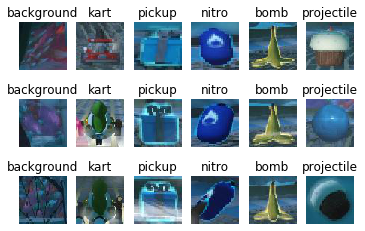

In [3]:
def visualize_data():

    Path_to_your_data= 'data/train/'
    dataset = SuperTuxDataset(image_path=Path_to_your_data)

    f, axes = plt.subplots(3, len(LABEL_NAMES))

    counts = [0]*len(LABEL_NAMES)

    for img, label in dataset:
        c = counts[label]

        if c < 3:
            ax = axes[c][label]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.axis('off')
            ax.set_title(LABEL_[label])
            counts[label] += 1
        
        if sum(counts) >= 3 * len(LABEL_NAMES):
            break

    plt.show()

visualize_data()

## Defining Model Architecture and Loss

In [4]:
class ClassificationLoss(torch.nn.Module):
    def forward(self, input, target):
        """
        Your code here
        Compute mean(-log(softmax(input)_label))
        @input:  torch.Tensor((B,C)), where B = batch size, C = number of classes
        @target: torch.Tensor((B,), dtype=torch.int64)
        @return:  torch.Tensor((,))
        Hint: Don't be too fancy, this is a one-liner
        """
        # raise NotImplementedError('ClassificationLoss.forward')
        super(ClassificationLoss,self).__init__()

        prob = F.softmax(input,dim=1)
        idx = target.long().view(-1,1)
        input_label = prob.gather(1,idx)
        loss = -torch.log(input_label)
        loss = torch.mean(loss)

        return loss

class CNNClassifier(torch.nn.Module):
    def __init__(self):
        """
        Your code here
        """
        #raise NotImplementedError('CNNClassifier.__init__')
        super(CNNClassifier,self).__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(3,6,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            # torch.nn.Dropout2d(0.25)
            torch.nn.BatchNorm2d(6)
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(6,12,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            # torch.nn.Dropout2d(0.25)
            torch.nn.BatchNorm2d(12)
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(12,20,kernel_size=3,stride=1,padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            # torch.nn.Dropout2d(0.25)
            torch.nn.BatchNorm2d(20)
        )

        self.fc = torch.nn.Sequential(
            torch.nn.Linear(20*8*8,400),
            torch.nn.Linear(400,120),
            torch.nn.Linear(120,6)
        )

    def forward(self, x):
        """
        Your code here
        @x: torch.Tensor((B,3,64,64))
        @return: torch.Tensor((B,6))
        """
        #raise NotImplementedError('CNNClassifier.forward')
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = x.view(x.size(0),-1)    # flat

        x = self.fc(x)

        return x

In [5]:
from torch import save
from torch import load
from os import path

def save_model(model):
    if isinstance(model, CNNClassifier):
        return save(model.state_dict(), path.join(path.dirname(path.abspath('__file__')), 'cnn.th'))
    
    # raise ValueError("model type '%s' not supported!"%str(type(model)))


def load_model():
    r = CNNClassifier()
    r.load_state_dict(load(path.join(path.dirname(path.abspath('__file__')), 'cnn.th'), map_location='cpu'))
    return r

In [ ]:
# Implementing the optimization procedure

# Create a model, loss, optimizer
device = torch.device("cuda")
model = CNNClassifier().to(device)
criterion = ClassificationLoss()
optimizer = optim.SGD(model.parameters(),lr=0.007,momentum=0.9)

# load the data: training and validation
trainset = SuperTuxDataset(image_path='data/train/')
trainloader = torch.utils.data.DataLoader(trainset,batch_size=1024,
                                        shuffle=True)

validset = SuperTuxDataset(image_path='data/valid/')
validloader = torch.utils.data.DataLoader(validset,batch_size=1024,
                                        shuffle=False)

# Run SGD for several epochs
for epoch in range(125):    # loop over the dataset multiple times

    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        # get the inputs
        inputs,labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradient
        optimizer.zero_grad()

        # forward + backward + optimizer
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 200 mini-batches
            print('[%d,%5d] loss: %.3f' %
                    (epoch+1, i+1, running_loss/20))
            running_loss = 0.0

print('Finished Training')

# save trained model
save_model(model)

In [ ]:
# testing
def test(model, device, test_loader):
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            test_loss += F.nll_loss(outputs,labels,reduction='sum').item()
            pred = outputs.argmax(dim=1,keepdim=True)
            correct +=pred.eq(labels.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.* correct / len(test_loader.dataset)))

test(model,device,validloader)

## Tensorboard logging

In [ ]:
def test_logging(train_logger, valid_logger):

    """
    Your code here.
    Finish logging the dummy loss and accuracy
    Log the loss every iteration, the accuracy only after each epoch
    Make sure to set global_step correctly, for epoch=0, iteration=0: global_step=0
    Call the loss 'loss', and accuracy 'accuracy' (no slash or other namespace)
    """

    # This is a strongly simplified training loop
    global_step = 0
    log_interval = 1
    size_train = 20
    size_valid = 10
    num_step_per_epoch_train = len([i for i in range(size_train) if i%log_interval==0])
    num_step_per_epoch_test = len([i for i in range(size_valid) if i%log_interval==0])

    for epoch in range(10):
        torch.manual_seed(epoch)
        # loss = 0.0
        # accuracy = 0.0
        train_ls = []
        valid_ls =[]
        for iteration in range(size_train):
            dummy_train_loss = 0.9**(epoch+iteration/20.)
            dummy_train_accuracy = epoch/10. + torch.randn(10)
            # raise NotImplementedError('Log the training loss')
            if i % log_interval == 0:
                train_logger.add_scalar('training loss',dummy_train_loss,epoch*num_step_per_epoch_train+global_step)
                dummy_train_accuracy_mean = torch.mean(dummy_train_accuracy)
                train_ls.append(dummy_train_accuracy_mean)
                global_step+=1

        # raise NotImplementedError('Log the training accuracy')
        train_after_iteration = torch.mean(torch.FloatTensor(train_ls))
        train_logger.add_scalar('training accuracy',train_after_iteration,epoch)

        torch.manual_seed(epoch)
        for iteration in range(size_valid):
            dummy_validation_accuracy = epoch / 10. + torch.randn(10)

            if i % log_interval == 0:
                dummy_validation_accuracy_mean = torch.mean(dummy_validation_accuracy)
                valid_ls.append(dummy_validation_accuracy_mean)

        #raise NotImplementedError('Log the validation accuracy')
        valid_after_iteration = torch.mean(torch.FloatTensor(valid_ls))
        valid_logger.add_scalar('valid accuracy',valid_after_iteration,epoch)


After implementing `test_logging()`, call it below. This should produce some plots on your tensorboard.

In [ ]:
%load_ext tensorboard

In [ ]:
%reload_ext tensorboard

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
ROOT_LOG_DIR = './logdir'

In [ ]:
%tensorboard --logdir {ROOT_LOG_DIR} #Launch tensorboard

In [ ]:
train_logger = tb.SummaryWriter(path.join('./logdir', 'train'))
valid_logger = tb.SummaryWriter(path.join('./logdir', 'test'))
test_logging(train_logger, valid_logger)

**Training and evaluation utility functions** 

Here are some implementations of useful functions for training and evaluating your models. Read these carefully. You may need to make some obvious edits before these will work.

In [6]:
def accuracy(outputs, labels):
    outputs_idx = outputs.max(1)[1].type_as(labels)
    return outputs_idx.eq(labels).float().mean()

def predict(model, inputs, device='cpu'):
    inputs = inputs.to(device)
    logits = model(inputs)
    return F.softmax(logits, -1)

def draw_bar(axis, preds, labels=None):
    y_pos = np.arange(6)
    axis.barh(y_pos, preds, align='center', alpha=0.5)
    axis.set_xticks(np.linspace(0, 1, 10))

    if labels:
        axis.set_yticks(y_pos)
        axis.set_yticklabels(labels)
    else:
        axis.get_yaxis().set_visible(False)

    axis.get_xaxis().set_visible(False)

def visualize_predictions():
  
    model = load_model()
    model.eval()

    validation_image_path='/data/valid' #enter the path 

    dataset = SuperTuxDataset(image_path=validation_image_path)

    f, axes = plt.subplots(2, 6)

    idxes = np.random.randint(0, len(dataset), size=6)

    for i, idx in enumerate(idxes):
        img, label = dataset[idx]
        preds = predict(model, img[None], device='cpu').detach().cpu().numpy()
        img = img.to(torch.float32)

        axes[0, i].imshow(torchvision.transforms.functional.to_pil_image(img))
        axes[0, i].axis('off')
        draw_bar(axes[1, i], preds[0], LABEL_ if i == 0 else None)

    plt.show()

## Training models

The `load_data` utility below uses your implementation of the dataset class above to provide a helper function that might be useful when you train your models. You won't need to change anything inside this function. 



In [7]:
def load_data(dataset_path, data_transforms=None, num_workers=0, batch_size=128):
    dataset = SuperTuxDataset(dataset_path,data_transforms)
    return DataLoader(dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True)

But you *will* need to implement `train()`, which takes an `args` object, that could have arbitrary arguments inside. We won't test your train function directly, but will instead evaluate the model it produces as output. To call `train`, you have to first create an args object, and add various attributes to it, as shown below:

In [8]:
class Args(object):
  def  __init__(self):
    self.learning_rate = 0.007
    self.log_dir = './logdir_data'
    self.momentum = 0.9
    self.epoch = 25
    self.device = "cuda"
    self.train_path = 'data/train/'
    self.valid_path = 'data/valid/'
    
args = Args();
# Add attributes to args here, such as:
# args.learning_rate = 0.0001
# args.log_dir = './my_tensorboard_log_directory' 

In [9]:
%load_ext tensorboard

In [10]:
%reload_ext tensorboard

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.tensorboard import SummaryWriter
ROOT_LOG_DIR = args.log_dir

In [11]:
%tensorboard --logdir {ROOT_LOG_DIR} --port 8084#Launch tensorboard

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 15700.

Then implement `train`. Follow the instructions in the assignment.

In [12]:
def train(args):
    """
    Your code here
    """
    # set up
    device = torch.device(args.device)
    model = CNNClassifier().to(device)
    criterion = ClassificationLoss()
    optimizer = optim.SGD(model.parameters(),lr = args.learning_rate, momentum = args.momentum)
    stepper = 0
    log_interval = 2

    # load the data
    trainset = SuperTuxDataset(image_path = args.train_path)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=1024,
                                            shuffle=True)
    validset = SuperTuxDataset(image_path=args.valid_path)
    validloader = torch.utils.data.DataLoader(validset,batch_size=1024,
                                            shuffle=True)
    
    size_train = len(trainloader)
    size_valid = len(validloader)
    train_acc = []
    valid_acc = []

    num_step_per_epoch = len([i for i in range(size_train) if i % log_interval == 0])

    if args.log_dir is not None:
        train_logger = tb.SummaryWriter(path.join(args.log_dir, 'train'))
        valid_logger = tb.SummaryWriter(path.join(args.log_dir, 'valid'))

    # raise NotImplementedError('train')
    for epoch in range(args.epoch):
        torch.manual_seed(epoch)
        train_ls =[]
        valid_ls =[]
        for iteration, data in enumerate(trainloader,0):
            inputs,labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # forward+backward+optimizer
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            train_accuracy = accuracy(outputs,labels)
            # train_accuracy = torch.mean(train_accuracy)
            loss.backward()
            optimizer.step()
            train_ls.append(train_accuracy)

            if iteration % log_interval == 0:
                train_logger.add_scalar('training loss',loss.item(),epoch*num_step_per_epoch+stepper)
                stepper += 1

        train_acc_after_iteration = torch.mean(torch.FloatTensor(train_ls))
        train_logger.add_scalar('training accuracy', train_acc_after_iteration,epoch)

        torch.manual_seed(epoch)
        for iteration, data in enumerate(validloader,0):
            inputs,labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            valid_accuracy = accuracy(outputs,labels)
            # valid_accuracy = torch.mean(valid_accuracy)
            valid_ls.append(valid_accuracy)

        valid_acc_after_iteration = torch.mean(torch.FloatTensor(valid_ls))
        valid_logger.add_scalar('valid accuracy',valid_acc_after_iteration,epoch)

    save_model(model)

Now, you can call `train` with `train(args)`, where `args` contains your various favorite settings of hyperparameters and other arguments that your implementation of `train` needs.


Afterwards, you can call `predict()' and `visualize_predictions()' to evaluate your model.

In [13]:
train(args)